In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Pillow requests -q
!pip install timm -q
!pip install --upgrade ultralytics -q
!pip install scalene -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.0 MB/s eta 0:00:00


In [ ]:
#Importing Libraires
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, ColorJitter, RandomPerspective
from torchvision.transforms import Lambda
from PIL import Image
import requests
from io import BytesIO
import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import timm
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

**Loading the mappings**

In [ ]:
def load_pickle_data(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data
file_path = '/content/mappings_Pinewood.pkl'
data = load_pickle_data(file_path)

print(data)


{'training_data/Pinewood\\2021-08\\VA_Pinewood_Virginia_Beach___2021-08-20_14-06-02-3314-05-00.jpg': -0.72, 'training_data/Pinewood\\2021-11\\VA_Pinewood_Virginia_Beach___2021-11-16_23-48-00-9716-05-00.jpg': -0.55, 'training_data/Pinewood\\2021-10\\VA_Pinewood_Virginia_Beach___2021-10-14_16-48-00-9082-05-00.jpg': 1.82, 'training_data/Pinewood\\2021-08\\VA_Pinewood_Virginia_Beach___2021-08-20_14-00-06-7267-05-00.jpg': -0.7, 'training_data/Pinewood\\2021-11\\VA_Pinewood_Virginia_Beach___2021-11-16_23-42-00-8947-05-00.jpg': -0.52, 'training_data/Pinewood\\2021-10\\VA_Pinewood_Virginia_Beach___2021-10-14_16-42-00-3249-05-00.jpg': 1.79, 'training_data/Pinewood\\2021-08\\VA_Pinewood_Virginia_Beach___2021-08-20_13-54-02-6426-05-00.jpg': -0.67, 'training_data/Pinewood\\2021-11\\VA_Pinewood_Virginia_Beach___2021-11-16_23-36-00-8522-05-00.jpg': -0.48, 'training_data/Pinewood\\2021-10\\VA_Pinewood_Virginia_Beach___2021-10-14_16-36-00-6504-05-00.jpg': 1.75, 'training_data/Pinewood\\2021-08\\VA_Pin

**Mapping The Masked Imgages WITHOUT_WATER To Water Meter Values**

In [ ]:
directory_path = '/content/drive/My Drive/IMAGES_RESULTS_MASKED_IMAGE_WITHOUT_WATER'

files = os.listdir(directory_path)

def get_last_34_chars(path):
    return path[-34:]

results = {}

for file in files:
    file_key = get_last_34_chars(file)
    for key, value in data.items():
        if get_last_34_chars(key) == file_key:
            results[os.path.join(directory_path,file)] = value

print(results)


{'/content/drive/My Drive/IMAGES_RESULTS_MASKED_IMAGE_WITHOUT_WATER/VA_Pinewood_Virginia_Beach___2021-10-04_08-48-01-0552-05-00.jpg': 0.79, '/content/drive/My Drive/IMAGES_RESULTS_MASKED_IMAGE_WITHOUT_WATER/VA_Pinewood_Virginia_Beach___2021-10-04_08-18-00-6034-05-00.jpg': 0.78, '/content/drive/My Drive/IMAGES_RESULTS_MASKED_IMAGE_WITHOUT_WATER/VA_Pinewood_Virginia_Beach___2021-10-04_08-42-00-7290-05-00.jpg': 0.8, '/content/drive/My Drive/IMAGES_RESULTS_MASKED_IMAGE_WITHOUT_WATER/VA_Pinewood_Virginia_Beach___2021-10-04_09-00-00-4877-05-00.jpg': 0.74, '/content/drive/My Drive/IMAGES_RESULTS_MASKED_IMAGE_WITHOUT_WATER/VA_Pinewood_Virginia_Beach___2021-10-04_08-30-15-4773-05-00.jpg': 0.8, '/content/drive/My Drive/IMAGES_RESULTS_MASKED_IMAGE_WITHOUT_WATER/VA_Pinewood_Virginia_Beach___2021-10-04_08-24-00-4938-05-00.jpg': 0.79, '/content/drive/My Drive/IMAGES_RESULTS_MASKED_IMAGE_WITHOUT_WATER/VA_Pinewood_Virginia_Beach___2021-10-04_08-36-00-4077-05-00.jpg': 0.8, '/content/drive/My Drive/IMAG

**Mapping The Masked Imgages WITH_WATER To Water Meter Values**

In [ ]:
directory_path = '/content/drive/My Drive/IMAGES_RESULTS_MASKED_IMAGE'

files = os.listdir(directory_path)

def get_last_34_chars(path):
    return path[-34:]

results_1 = {}

for file in files:
    file_key = get_last_34_chars(file)
    for key, value in data.items():
        if get_last_34_chars(key) == file_key:
            results_1[os.path.join(directory_path,file)] = value

print(results_1)


{'/content/drive/My Drive/IMAGES_RESULTS_MASKED_IMAGE/VA_Pinewood_Virginia_Beach___2021-10-04_08-48-01-0552-05-00.jpg': 0.79, '/content/drive/My Drive/IMAGES_RESULTS_MASKED_IMAGE/VA_Pinewood_Virginia_Beach___2021-10-04_08-18-00-6034-05-00.jpg': 0.78, '/content/drive/My Drive/IMAGES_RESULTS_MASKED_IMAGE/VA_Pinewood_Virginia_Beach___2021-10-04_08-42-00-7290-05-00.jpg': 0.8, '/content/drive/My Drive/IMAGES_RESULTS_MASKED_IMAGE/VA_Pinewood_Virginia_Beach___2021-10-04_09-00-00-4877-05-00.jpg': 0.74, '/content/drive/My Drive/IMAGES_RESULTS_MASKED_IMAGE/VA_Pinewood_Virginia_Beach___2021-10-04_08-30-15-4773-05-00.jpg': 0.8, '/content/drive/My Drive/IMAGES_RESULTS_MASKED_IMAGE/VA_Pinewood_Virginia_Beach___2021-10-04_08-24-00-4938-05-00.jpg': 0.79, '/content/drive/My Drive/IMAGES_RESULTS_MASKED_IMAGE/VA_Pinewood_Virginia_Beach___2021-10-04_08-36-00-4077-05-00.jpg': 0.8, '/content/drive/My Drive/IMAGES_RESULTS_MASKED_IMAGE/VA_Pinewood_Virginia_Beach___2021-10-04_08-54-00-4963-05-00.jpg': 0.77, '/

In [ ]:
print(type(results))

<class 'dict'>


**Model Training Mapped Images Without Water**

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, mappings, input_img_size, model_config, scaler=None, training=True):
        self.image_paths = list(mappings.keys())
        self.targets = [mappings[path] for path in self.image_paths]
        self.training = training

        if not scaler:
            self.scaler = StandardScaler()
            self.targets_scaled = self.scaler.fit_transform(np.array(self.targets).reshape(-1, 1)).flatten()
        else:
            self.scaler = scaler
            self.targets_scaled = self.scaler.transform(np.array(self.targets).reshape(-1, 1)).flatten()


        transforms_list = [ToPILImage(), Resize((input_img_size, input_img_size))]
        if self.training:
            transforms_list.extend([
                ColorJitter(brightness=(0.9, 1.2), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=0),
                RandomPerspective(distortion_scale=0.1)
            ])
        transforms_list.extend([
            ToTensor(),
            Normalize(mean=model_config['mean'], std=model_config['std'])
        ])
        self.transforms = Compose(transforms_list)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        target_scaled = self.targets_scaled[idx]
        image = read_image(image_path).float() / 255
        image = self.transforms(image)
        return image, target_scaled

    def reverse_scale(self, iterable):
        return self.scaler.inverse_transform(iterable.reshape(-1, 1)).flatten()

class EfficientNet(nn.Module):
    class RegressionLayers(nn.Module):
        def __init__(self, in_features):
            super(EfficientNet.RegressionLayers, self).__init__()
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(in_features, 1024),
                nn.GELU(),
                nn.Linear(1024, 512),
                nn.GELU(),
                nn.Linear(512, 128),
                nn.GELU(),
                nn.Linear(128, 1)
            )

        def forward(self, x):
            return self.layers(x.float())

    def __init__(self, device, param_freeze_ratio=0.5):
        super(EfficientNet, self).__init__()
        self.model = timm.create_model('tf_efficientnet_l2.ns_jft_in1k', pretrained=True)
        self.model.reset_classifier(0)

        total_params = sum(p.numel() for p in self.model.parameters())
        params_to_freeze = int(total_params * param_freeze_ratio)
        frozen_params_count = 0
        for param in self.model.parameters():
            if frozen_params_count >= params_to_freeze:
                break
            param.requires_grad = False
            frozen_params_count += param.numel()
        print(f"Froze {frozen_params_count} out of {total_params} parameters.")


        n_features = self.model.forward_features(torch.randn(1, 3, 224, 224)).shape[1]
        self.model.classifier = EfficientNet.RegressionLayers(n_features)
        self.model = self.model.to(device)

    def forward(self, x):
        return self.model.forward(x)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_img_size = 224
batch_size = 4
learning_rate = 1e-4
num_epochs = 40

# Splitting the dataset
image_paths = list(results.keys())
targets = [results[path] for path in image_paths]
image_paths_train, image_paths_test, targets_train, targets_test = train_test_split(
    image_paths, targets, test_size=0.2, random_state=42
)

# Normalizing target values
scaler = StandardScaler()
targets_scaled_train = scaler.fit_transform(np.array(targets_train).reshape(-1, 1)).flatten()
targets_scaled_test = scaler.transform(np.array(targets_test).reshape(-1, 1)).flatten()

# Creating training and testing datasets
train_dataset = Dataset(dict(zip(image_paths_train, targets_scaled_train)), input_img_size,
                        {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}, training=True)
test_dataset = Dataset(dict(zip(image_paths_test, targets_scaled_test)), input_img_size,
                       {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}, training=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model training
model = EfficientNet(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

model.train()
loss_history = []
for epoch in range(num_epochs):
    total_loss = 0
    for images, targets in tqdm(train_loader):
        images, targets = images.to(device), targets.to(device).float()  # Ensure targets are float
        optimizer.zero_grad()
        outputs = model(images).flatten()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss}")

# Model evaluation
model.eval()
predictions_Without_Water, actuals = [], []
with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)
        outputs = model(images).flatten().cpu()
        predictions_Without_Water.extend(test_dataset.reverse_scale(outputs.numpy()))
        actuals.extend(test_dataset.reverse_scale(targets.cpu().numpy()))

rmse = np.sqrt(mean_squared_error(actuals, predictions_Without_Water))
print(f"Test RMSE: {rmse}")


Froze 239291948 out of 474804308 parameters.


100%|██████████| 22/22 [00:14<00:00,  1.48it/s]


Epoch 1, Average Loss: 0.9356006820770827


100%|██████████| 22/22 [00:14<00:00,  1.47it/s]


Epoch 2, Average Loss: 0.6845178637992252


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 3, Average Loss: 0.5656549002636563


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 4, Average Loss: 0.47362816672433505


100%|██████████| 22/22 [00:14<00:00,  1.48it/s]


Epoch 5, Average Loss: 0.36857745999639685


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 6, Average Loss: 0.27438038181174884


100%|██████████| 22/22 [00:14<00:00,  1.48it/s]


Epoch 7, Average Loss: 0.31179112602363934


100%|██████████| 22/22 [00:14<00:00,  1.49it/s]


Epoch 8, Average Loss: 0.2236822879111225


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 9, Average Loss: 0.21569181580773808


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 10, Average Loss: 0.3373398757116361


100%|██████████| 22/22 [00:14<00:00,  1.49it/s]


Epoch 11, Average Loss: 0.23974512335421008


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 12, Average Loss: 0.1478177652143958


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 13, Average Loss: 0.15654013805430045


100%|██████████| 22/22 [00:14<00:00,  1.48it/s]


Epoch 14, Average Loss: 0.1404370950450274


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 15, Average Loss: 0.1577044299338013


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 16, Average Loss: 0.08633553575385701


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 17, Average Loss: 0.12097277970645916


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 18, Average Loss: 0.13208184044130825


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 19, Average Loss: 0.10999359698458151


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 20, Average Loss: 0.06940771918743849


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 21, Average Loss: 0.06171454895626415


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 22, Average Loss: 0.10168069541792978


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 23, Average Loss: 0.07469422518360344


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 24, Average Loss: 0.08043943311680447


100%|██████████| 22/22 [00:14<00:00,  1.52it/s]


Epoch 25, Average Loss: 0.09088857160796496


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 26, Average Loss: 0.06440374009649862


100%|██████████| 22/22 [00:14<00:00,  1.49it/s]


Epoch 27, Average Loss: 0.052507869179614565


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 28, Average Loss: 0.05053555592894554


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 29, Average Loss: 0.07675557496788149


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 30, Average Loss: 0.07479269763412462


100%|██████████| 22/22 [00:14<00:00,  1.52it/s]


Epoch 31, Average Loss: 0.06131423443333584


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 32, Average Loss: 0.0836575125259432


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 33, Average Loss: 0.07824198266660626


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 34, Average Loss: 0.06737335290844468


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 35, Average Loss: 0.050138445613397795


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 36, Average Loss: 0.04978052158416672


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 37, Average Loss: 0.05583231938494877


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 38, Average Loss: 0.03612563591873781


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 39, Average Loss: 0.050435146846046504


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 40, Average Loss: 0.06118713804012672
Test RMSE: 0.2955106241869725


In [ ]:
torch.save(model.state_dict(), 'efficientnet_model_Without_Water.pth')
torch.save(model, 'efficientnet_full_model_Without_Water.pth')

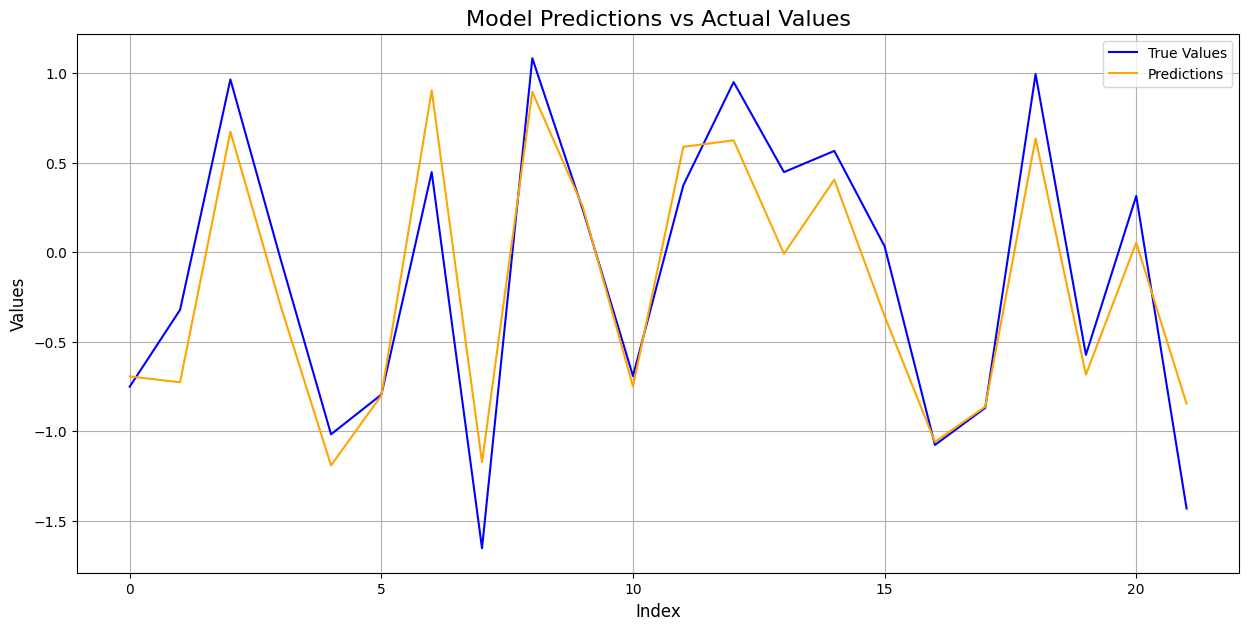

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 7))  # Adjust the figure size as needed
ax.plot(actuals, label='True Values', color='blue')  # Blue line for actual values
ax.plot(predictions_Without_Water, label='Predictions', color='orange')  # Orange line for predictions
ax.set_title('Model Predictions vs Actual Values', fontsize=16)
ax.set_xlabel('Index', fontsize=12)
ax.set_ylabel('Values', fontsize=12)
ax.legend()
ax.grid(True)
plt.show()


**Model Training Mapped Images With Water**

In [ ]:
# Dataset class with Data Augmentation results
class Dataset(torch.utils.data.Dataset):
    def __init__(self, mappings, input_img_size, model_config, scaler=None, training=True):
        self.image_paths = list(mappings.keys())
        self.targets = [mappings[path] for path in self.image_paths]
        self.training = training

        if not scaler:
            self.scaler = StandardScaler()
            self.targets_scaled = self.scaler.fit_transform(np.array(self.targets).reshape(-1, 1)).flatten()
        else:
            self.scaler = scaler
            self.targets_scaled = self.scaler.transform(np.array(self.targets).reshape(-1, 1)).flatten()

        # Data augmentation for training
        transforms_list = [ToPILImage(), Resize((input_img_size, input_img_size))]
        if self.training:
            transforms_list.extend([
                ColorJitter(brightness=(0.9, 1.2), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=0),
                RandomPerspective(distortion_scale=0.1)
            ])
        transforms_list.extend([
            ToTensor(),
            Normalize(mean=model_config['mean'], std=model_config['std'])
        ])
        self.transforms = Compose(transforms_list)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        target_scaled = self.targets_scaled[idx]
        image = read_image(image_path).float() / 255
        image = self.transforms(image)
        return image, target_scaled

    def reverse_scale(self, iterable):
        return self.scaler.inverse_transform(iterable.reshape(-1, 1)).flatten()


# Model class with Parameter Freezing
class EfficientNet(nn.Module):
    class RegressionLayers(nn.Module):
        def __init__(self, in_features):
            super(EfficientNet.RegressionLayers, self).__init__()
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(in_features, 1024),
                nn.GELU(),
                nn.Linear(1024, 512),
                nn.GELU(),
                nn.Linear(512, 128),
                nn.GELU(),
                nn.Linear(128, 1)
            )

        def forward(self, x):
            return self.layers(x.float())

    def __init__(self, device, param_freeze_ratio=0.5):
        super(EfficientNet, self).__init__()
        self.model = timm.create_model('tf_efficientnet_l2.ns_jft_in1k', pretrained=True)
        self.model.reset_classifier(0)

        # Freezing parameters based on the ratio
        total_params = sum(p.numel() for p in self.model.parameters())
        params_to_freeze = int(total_params * param_freeze_ratio)
        frozen_params_count = 0
        for param in self.model.parameters():
            if frozen_params_count >= params_to_freeze:
                break
            param.requires_grad = False
            frozen_params_count += param.numel()
        print(f"Froze {frozen_params_count} out of {total_params} parameters.")

        # Calculate the number of features dynamically
        n_features = self.model.forward_features(torch.randn(1, 3, 224, 224)).shape[1]
        self.model.classifier = EfficientNet.RegressionLayers(n_features)
        self.model = self.model.to(device)

    def forward(self, x):
        return self.model.forward(x)


# Main execution setup with Batch Size and Learning Rate adjustments
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_img_size = 224
batch_size = 4
learning_rate = 1e-4
num_epochs = 40

# Splitting the dataset
image_paths = list(results_1.keys())
targets = [results_1[path] for path in image_paths]
image_paths_train, image_paths_test, targets_train, targets_test = train_test_split(
    image_paths, targets, test_size=0.2, random_state=42
)

# Normalizing target values
scaler = StandardScaler()
targets_scaled_train = scaler.fit_transform(np.array(targets_train).reshape(-1, 1)).flatten()
targets_scaled_test = scaler.transform(np.array(targets_test).reshape(-1, 1)).flatten()

# Creating training and testing datasets
train_dataset = Dataset(dict(zip(image_paths_train, targets_scaled_train)), input_img_size,
                        {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}, training=True)
test_dataset = Dataset(dict(zip(image_paths_test, targets_scaled_test)), input_img_size,
                       {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}, training=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model training
model = EfficientNet(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

model.train()
loss_history = []
for epoch in range(num_epochs):
    total_loss = 0
    for images, targets in tqdm(train_loader):
        images, targets = images.to(device), targets.to(device).float()  # Ensure targets are float
        optimizer.zero_grad()
        outputs = model(images).flatten()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss}")

# Model evaluation
model.eval()
predictions_With_Water, actuals = [], []
with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)
        outputs = model(images).flatten().cpu()
        predictions_With_Water.extend(test_dataset.reverse_scale(outputs.numpy()))
        actuals.extend(test_dataset.reverse_scale(targets.cpu().numpy()))

rmse = np.sqrt(mean_squared_error(actuals, predictions_With_Water))
print(f"Test RMSE: {rmse}")


Froze 239291948 out of 474804308 parameters.


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 1, Average Loss: 0.8999857367439703


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 2, Average Loss: 0.634003936228427


100%|██████████| 22/22 [00:14<00:00,  1.48it/s]


Epoch 3, Average Loss: 0.453619370744987


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 4, Average Loss: 0.5476437456567179


100%|██████████| 22/22 [00:14<00:00,  1.52it/s]


Epoch 5, Average Loss: 0.5049389820884574


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 6, Average Loss: 0.3748056248507716


100%|██████████| 22/22 [00:14<00:00,  1.52it/s]


Epoch 7, Average Loss: 0.46375131293792615


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 8, Average Loss: 0.37922871713949874


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 9, Average Loss: 0.42847778648138046


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 10, Average Loss: 0.3990985930643298


100%|██████████| 22/22 [00:14<00:00,  1.52it/s]


Epoch 11, Average Loss: 0.37610916285352275


100%|██████████| 22/22 [00:14<00:00,  1.52it/s]


Epoch 12, Average Loss: 0.24420606040141798


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 13, Average Loss: 0.337278697301041


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 14, Average Loss: 0.25258744694292545


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 15, Average Loss: 0.1613591458987106


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 16, Average Loss: 0.16862775851041079


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 17, Average Loss: 0.140794768051075


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 18, Average Loss: 0.2686966761301102


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


Epoch 19, Average Loss: 0.19004603665830058


100%|██████████| 22/22 [00:14<00:00,  1.51it/s]


Epoch 20, Average Loss: 0.13184516423974524


100%|██████████| 22/22 [00:14<00:00,  1.49it/s]


Epoch 21, Average Loss: 0.14538148291070352


100%|██████████| 22/22 [00:14<00:00,  1.49it/s]


Epoch 22, Average Loss: 0.15915075143460522


100%|██████████| 22/22 [00:15<00:00,  1.46it/s]


Epoch 23, Average Loss: 0.10343079184266654


100%|██████████| 22/22 [00:15<00:00,  1.46it/s]


Epoch 24, Average Loss: 0.09877789249135689


100%|██████████| 22/22 [00:14<00:00,  1.47it/s]


Epoch 25, Average Loss: 0.15590139630843292


100%|██████████| 22/22 [00:14<00:00,  1.47it/s]


Epoch 26, Average Loss: 0.127385289831595


100%|██████████| 22/22 [00:14<00:00,  1.47it/s]


Epoch 27, Average Loss: 0.11290145220912316


100%|██████████| 22/22 [00:15<00:00,  1.46it/s]


Epoch 28, Average Loss: 0.14108769900419496


100%|██████████| 22/22 [00:14<00:00,  1.47it/s]


Epoch 29, Average Loss: 0.08182136312296445


100%|██████████| 22/22 [00:14<00:00,  1.49it/s]


Epoch 30, Average Loss: 0.1534963330328041


100%|██████████| 22/22 [00:14<00:00,  1.48it/s]


Epoch 31, Average Loss: 0.1312573005601404


100%|██████████| 22/22 [00:14<00:00,  1.49it/s]


Epoch 32, Average Loss: 0.10716980441727421


100%|██████████| 22/22 [00:14<00:00,  1.49it/s]


Epoch 33, Average Loss: 0.11389629731208763


100%|██████████| 22/22 [00:14<00:00,  1.48it/s]


Epoch 34, Average Loss: 0.06827619705687869


100%|██████████| 22/22 [00:14<00:00,  1.49it/s]


Epoch 35, Average Loss: 0.11113319905813444


100%|██████████| 22/22 [00:14<00:00,  1.48it/s]


Epoch 36, Average Loss: 0.08330827828666026


100%|██████████| 22/22 [00:14<00:00,  1.48it/s]


Epoch 37, Average Loss: 0.09402196276509626


100%|██████████| 22/22 [00:14<00:00,  1.48it/s]


Epoch 38, Average Loss: 0.10689871256578375


100%|██████████| 22/22 [00:14<00:00,  1.48it/s]


Epoch 39, Average Loss: 0.09597064357843589


100%|██████████| 22/22 [00:14<00:00,  1.49it/s]


Epoch 40, Average Loss: 0.08330956524745985
Test RMSE: 0.3412963771808131


In [ ]:
torch.save(model.state_dict(), 'efficientnet_model_With_Water.pth')
torch.save(model, 'efficientnet_full_model_With_Water.pth')

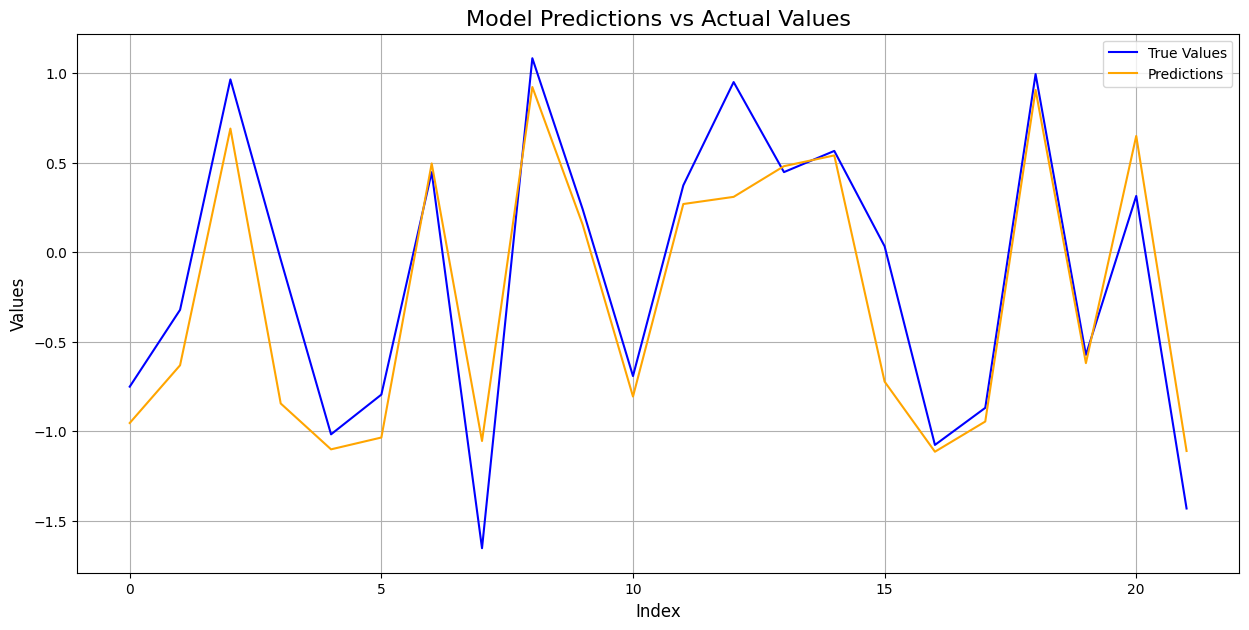

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(actuals, label='True Values', color='blue')
ax.plot(predictions_With_Water, label='Predictions', color='orange')
ax.set_title('Model Predictions vs Actual Values', fontsize=16)
ax.set_xlabel('Index', fontsize=12)
ax.set_ylabel('Values', fontsize=12)
ax.legend()
ax.grid(True)
plt.show()


**Comparing The Trained model Results With prev Model**

In [ ]:
df = pd.read_excel('/content/Pinewood_validation_results_test.xlsx')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7196 entries, 0 to 7195
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   y_pred     7196 non-null   float64
 1   y_true     7196 non-null   float64
 2   Diff       7196 non-null   float64
 3   image_url  7196 non-null   object 
dtypes: float64(3), object(1)
memory usage: 225.0+ KB


In [ ]:
df=df.head()

In [ ]:
df= df.sample(n=100, random_state=42)

In [ ]:
subset_df = df[['image_url', 'y_true']]
result_dict = dict(zip(subset_df['image_url'], subset_df['y_true']))
print(result_dict)


{'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-01T00:00:00.jpg': -0.03, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-01T00:06:00.jpg': -0.07, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-01T00:12:00.jpg': -0.12, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-01T00:18:00.jpg': -0.16, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-01T00:24:00.jpg': -0.2}


**model_With_Water**

In [ ]:
output_folder = '/content/drive/My Drive/MODEL_COMPARISION_2'
os.makedirs(output_folder, exist_ok=True)

# Initialize the YOLO model
model = YOLO('/content/best (2).pt')

# Dictionary to store URL to processed path mapping
url_to_path_dict = {}

# Process each URL
for image_url, target in result_dict.items():
    # Download the image
    response = requests.get(image_url, stream=True)
    if response.status_code == 200:
        image_name = os.path.basename(image_url)
        input_path = os.path.join(output_folder, f"temp_{image_name}")
        with open(input_path, 'wb') as file:
            file.write(response.content)

        # Run the YOLO model
        results = model(input_path, save=True)
        img = cv2.imread(input_path)
        output_path = os.path.join(output_folder, image_name)

        # Create the mask and isolate the region
        mask_data = results[0].masks.cpu().numpy()
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for contour in results[0].masks.xy:
            cv2.drawContours(mask, [contour.astype(np.int32)], -1, (255), cv2.FILLED)
        mask_3d = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        isolated = cv2.bitwise_and(img, mask_3d)
        cv2.imwrite(output_path, isolated)

        # Map the URL to the processed image path
        url_to_path_dict[image_url] = output_path
        print(f"Processed and saved: {output_path}")

        # Optionally delete the temporary input file
        os.remove(input_path)
    else:
        print(f"Failed to download image: {image_url}")

# Print or save the mapping
print("URL to Processed Path Mapping:", url_to_path_dict)



image 1/1 /content/drive/My Drive/MODEL_COMPARISION_2/temp_2022-01-15T09:12:00.jpg: 768x1024 1 water_gauge_2, 15.9ms
Speed: 5.6ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)
Results saved to runs/segment/predict14
Processed and saved: /content/drive/My Drive/MODEL_COMPARISION_2/2022-01-15T09:12:00.jpg

image 1/1 /content/drive/My Drive/MODEL_COMPARISION_2/temp_2022-01-23T00:12:00.jpg: 768x1024 1 water_gauge_2, 15.2ms
Speed: 6.4ms preprocess, 15.2ms inference, 2.1ms postprocess per image at shape (1, 3, 768, 1024)
Results saved to runs/segment/predict14
Processed and saved: /content/drive/My Drive/MODEL_COMPARISION_2/2022-01-23T00:12:00.jpg

image 1/1 /content/drive/My Drive/MODEL_COMPARISION_2/temp_2022-01-29T02:24:00.jpg: 768x1024 1 water_gauge_2, 15.2ms
Speed: 5.9ms preprocess, 15.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)
Results saved to runs/segment/predict14
Processed and saved: /content/drive/My Drive/MODEL_COM

In [ ]:
# Load the saved model
model = torch.load('efficientnet_full_model_With_Water.pth')
model.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define transformations
transform = Compose([
    Resize((224, 224)),  # Ensure dimensions match those used during training
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load image from URL
def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

# Function to predict from URL
def predict_from_url(url, model, transform):
    try:
        image = load_image_from_url(url)
        image = transform(image).unsqueeze(0)  # Add batch dimension
        image = image.to(device)  # Move to the same device as model
        with torch.no_grad():
            prediction = model(image).flatten()
            return prediction.cpu().item()  # Move data to CPU and convert to numpy, then get scalar
    except Exception as e:
        print(f"Error processing {url}: {e}")
        return None

# Assuming result_dict is already defined
# Example dictionary, replace with actual URLs and values
# result_dict = {'http://example.com/image1.jpg': 0.5, 'http://example.com/image2.jpg': 0.6}
predictions_With_Water_2 = {url: predict_from_url(url, model, transform) for url in url_to_path_dict.keys()}

print(predictions_With_Water_2)


{'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-15T09:12:00.jpg': -56052465664.0, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-23T00:12:00.jpg': 1.104870319366455, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-29T02:24:00.jpg': 1.0045288801193237, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-16T17:24:00.jpg': -205869520.0, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-07T23:00:00.jpg': 1.1022182703018188, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-14T09:24:00.jpg': -169682042880.0, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-15T08:48:00.jpg': -533677637632.0, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-01T13:48:00.jpg': -203682400.0, 'https://ngwos-imagery.s3.amazonaws.co

**model_Without_Water**

In [ ]:

output_folder = '/content/drive/My Drive/MODEL_COMPARISION'
os.makedirs(output_folder, exist_ok=True)

# Initialize the YOLO model
model = YOLO('/content/best (3).pt')

# Dictionary to store URL to processed path mapping
url_to_path_dict = {}

# Process each URL
for image_url, target in result_dict.items():
    # Download the image
    response = requests.get(image_url, stream=True)
    if response.status_code == 200:
        image_name = os.path.basename(image_url)
        input_path = os.path.join(output_folder, f"temp_{image_name}")
        with open(input_path, 'wb') as file:
            file.write(response.content)

        # Run the YOLO model
        results = model(input_path, save=True)
        img = cv2.imread(input_path)
        output_path = os.path.join(output_folder, image_name)

        # Create the mask and isolate the region
        mask_data = results[0].masks.cpu().numpy()
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for contour in results[0].masks.xy:
            cv2.drawContours(mask, [contour.astype(np.int32)], -1, (255), cv2.FILLED)
        mask_3d = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        isolated = cv2.bitwise_and(img, mask_3d)
        cv2.imwrite(output_path, isolated)

        # Map the URL to the processed image path
        url_to_path_dict[image_url] = output_path
        print(f"Processed and saved: {output_path}")

        # Optionally delete the temporary input file
        os.remove(input_path)
    else:
        print(f"Failed to download image: {image_url}")

# Print or save the mapping
print("URL to Processed Path Mapping:", url_to_path_dict)



image 1/1 /content/drive/My Drive/MODEL_COMPARISION/temp_2022-01-15T09:12:00.jpg: 768x1024 1 water_gauge_2, 15.7ms
Speed: 5.5ms preprocess, 15.7ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)
Results saved to runs/segment/predict15
Processed and saved: /content/drive/My Drive/MODEL_COMPARISION/2022-01-15T09:12:00.jpg

image 1/1 /content/drive/My Drive/MODEL_COMPARISION/temp_2022-01-23T00:12:00.jpg: 768x1024 1 water_gauge_2, 15.2ms
Speed: 5.8ms preprocess, 15.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)
Results saved to runs/segment/predict15
Processed and saved: /content/drive/My Drive/MODEL_COMPARISION/2022-01-23T00:12:00.jpg

image 1/1 /content/drive/My Drive/MODEL_COMPARISION/temp_2022-01-29T02:24:00.jpg: 768x1024 1 water_gauge_2, 15.2ms
Speed: 6.0ms preprocess, 15.2ms inference, 2.0ms postprocess per image at shape (1, 3, 768, 1024)
Results saved to runs/segment/predict15
Processed and saved: /content/drive/My Drive/MODEL_COMPARISION/2

In [ ]:
# Load the saved model
model = torch.load('efficientnet_full_model_Without_Water.pth')
model.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define transformations
transform = Compose([
    Resize((224, 224)),  # Ensure dimensions match those used during training
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load image from URL
def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

# Function to predict from URL
def predict_from_url(url, model, transform):
    try:
        image = load_image_from_url(url)
        image = transform(image).unsqueeze(0)  # Add batch dimension
        image = image.to(device)  # Move to the same device as model
        with torch.no_grad():
            prediction = model(image).flatten()
            return prediction.cpu().item()  # Move data to CPU and convert to numpy, then get scalar
    except Exception as e:
        print(f"Error processing {url}: {e}")
        return None

# Assuming result_dict is already defined
# Example dictionary, replace with actual URLs and values
# result_dict = {'http://example.com/image1.jpg': 0.5, 'http://example.com/image2.jpg': 0.6}
predictions_Without_Water_2 = {url: predict_from_url(url, model, transform) for url in url_to_path_dict.keys()}

print(predictions_Without_Water_2)


{'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-15T09:12:00.jpg': 3875232256.0, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-23T00:12:00.jpg': 48784920.0, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-29T02:24:00.jpg': -0.8035470843315125, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-16T17:24:00.jpg': 9890230272.0, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-07T23:00:00.jpg': 1730622390272.0, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-14T09:24:00.jpg': 950345344.0, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-15T08:48:00.jpg': 372445020160.0, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d-4cca-b9b8-9ae4c78652af/2022-01-01T13:48:00.jpg': 10262380544.0, 'https://ngwos-imagery.s3.amazonaws.com/b6e90a1f-691d